In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# Define a Goal
Our Goal is to create a Network Intrusion Detection System (NIDS).
Categorize each object that is a raw packet as:
- Attack or Not Attack (label 1 or 0)
- Category of the Attack.  

Using a **Supervised Classificator**, our model will be able to classify a packet captured in **Malicious** or not.

# Data AcQuisition (DAQ)
We used a non cleaned dataset found on kaggle.com: **UNSW-NB15**. The raw packet was created by the *'IXIA PerfectStorm tool'*. This dataset is a labeled datset and in particular has nine types of attacks: 
- Generic: Techniques used against all block-cypher.
- Fuzzers: Send random data to find vulnerabilities.
- Backdoors: Hidden access for unauthorized control.
- DoS: Overwhelm a system to disrupt service.
- Exploits: Use vulnerabilities for unauthorized access.
- Reconnaissance: Gather info to find vulnerabilities.
- Shellcode: Malicious code for system control.
- Worms: Self-spreading malware across networks.
- Analysis:  Gathering info for exploitation.

First we assign a column name according to *NUSW-NB15_features.csv*.

In [2]:
column_name = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur',
    'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service',
    'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb',
    'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit',
    'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
    'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
    'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
    'Label'
]
df = pd.read_csv('UNSW-NB15_4.csv', header=None, names=column_name)

# Data Exploration
The exploration of the data is made in order to identify the dataset content, to extract and visualize data. We will use this in order to indentify possible features in the dataset that we do not want.

In [3]:
df = df.drop_duplicates()
df.head(10)

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,...,,2,2,7,4,1,1,3,NaN,0
1,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,...,,3,1,4,4,1,1,1,NaN,0
2,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,...,,3,5,2,7,1,1,4,NaN,0
3,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,...,,1,1,4,7,1,1,3,NaN,0
4,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,...,,2,5,2,1,1,1,2,NaN,0
5,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,...,,9,7,2,3,2,1,6,NaN,0
6,175.45.176.0,49582,149.171.126.12,80,tcp,FIN,0.189983,13304,268,254,...,,1,1,1,1,1,1,1,Exploits,1
7,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Fuzzers,1
8,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Exploits,1
11,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Backdoor,1


We make a describe() only for usefull feature:
- Dur: Analyzes the duration of connections.
- Sbytes, Dbytes: Amount of bytes exchanged between source and destination.
- Sload, Dload: Data transmission speed.
- Spkts, Dpkts: Number of packets sent and received.
- Sjit, Djit: Jitter of the connection (variation in delay).
- Sintpkt, Dintpkt: Interval between packets.
- Tcprtt, Synack, Ackdat: TCP round-trip time, SYN-ACK, and acknowledgment time.

In [4]:
column_described = [
    'dur', 'sbytes', 'dbytes', 'Sload', 'Dload', 'sloss', 'dloss',
    'Spkts', 'Dpkts', 'Sjit', 'Djit',
    'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat'
]

df[column_described].describe()


,dur,sbytes,dbytes,Sload,Dload,sloss,dloss,Spkts,Dpkts,Sjit,Djit,Sintpkt,Dintpkt,tcprtt,synack,ackdat
count,306719.000000,3.067190e+05,3.067190e+05,3.067190e+05,3.067190e+05,306719.000000,306719.000000,306719.000000,306719.000000,3.067190e+05,306719.000000,306719.000000,306719.000000,306719.000000,306719.000000,306719.000000
mean,0.667638,5.290531e+03,3.829690e+04,1.559210e+07,2.793255e+06,5.932414,17.427831,36.311018,46.010296,1.709003e+03,745.345346,155.636839,66.161261,0.012234,0.006456,0.005778
std,3.484700,7.808057e+04,1.629300e+05,9.581792e+07,4.430833e+06,30.319159,57.324461,85.554745,122.105238,1.472759e+04,2278.464267,2425.300693,1233.431546,0.080375,0.046563,0.041447
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001806,4.240000e+02,2.680000e+02,7.811491e+04,6.913363e+04,0.000000,0.000000,4.000000,4.000000,0.000000e+00,0.270590,0.254869,0.203000,0.000000,0.000000,0.000000
50%,0.023896,1.580000e+03,2.456000e+03,5.483568e+05,6.618999e+05,4.000000,4.000000,14.000000,18.000000,3.271329e+01,17.596372,0.776978,0.692854,0.000631,0.000502,0.000123
75%,0.346955,3.406000e+03,1.703000e+04,1.194410e+06,3.627428e+06,7.000000,15.000000,48.000000,44.000000,7.722584e+02,80.645797,12.723077,10.698917,0.000706,0.000562,0.000140
max,59.999989,1.106347e+07,1.283855e+07,5.600000e+09,2.290690e+07,4158.000000,4829.000000,8324.000000,9660.000000,1.201182e+06,120773.448400,84371.496000,52133.240000,10.037506,4.525272,5.512234


## Validating value 0 for the Duration of the packet
Value 0 in duration could be an error. let's compare it with other values relevant like *sbytes, dbytes, Sjit, Djit, sloss, or dloss*.

In [5]:
dur_zero = df[df['dur'] == 0]

In [6]:
columns_of_interest = ['sbytes', 'dbytes', 'Sjit', 'Djit', 'sloss', 'dloss']
dur_zero[columns_of_interest].describe()

,sbytes,dbytes,Sjit,Djit,sloss,dloss
count,389.000000,389.0,389.000000,389.0,389.0,389.0
mean,51.246787,0.0,4.065893,0.0,0.0,0.0
std,74.757552,0.0,6.188250,0.0,0.0,0.0
min,28.000000,0.0,0.000000,0.0,0.0,0.0
25%,46.000000,0.0,0.000000,0.0,0.0,0.0
50%,46.000000,0.0,0.000000,0.0,0.0,0.0
75%,46.000000,0.0,10.954515,0.0,0.0,0.0
max,1504.000000,0.0,15.492038,0.0,0.0,0.0


Instead it seems that everything is ok because every packet with *dur == 0* have a *sbytes* not zero and instead the *dbytes* are zero so no bytes are sent back to the source, this can due to a specific type of packet that do not need a response immmediately (UDP) or due to an error communication.
No packet loss is encountered so it is ok that the duration is zero because no retrasmission is needed. Jitter in the source *Sjit* with *mean* that low *4.0 ms* is ok, probably the max *15.5 ms* is an error because we are considering *dur* 0.   

We have seen that a low *jitter* is ok even if the duration is zero, this because the jitter is not related to a single packet but a record of packets that can have *dur* not equal to 0.

## Label Visualization
Explore if the dataset is balanced or not.

In [7]:
label_1_count = df['Label'].value_counts().get(1, 0)
print(f'Malicious packets: {label_1_count}')

Malicious packets: 25257


In [8]:
label_0_count = df['Label'].value_counts().get(0, 0)
print(f'Normal packets: {label_0_count}')

Normal packets: 281462


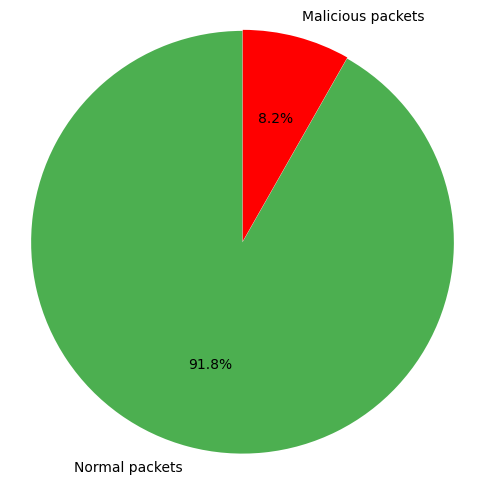

In [9]:
labels = ['Normal packets', 'Malicious packets']
sizes = [label_0_count, label_1_count]
colors = ['#4CAF50', '#FF0000']  

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.005, 0)) 
plt.axis('equal')
plt.show()

The dataset is **unbalanced**.

Now let's visualize the Attack Category one by one counting them.

In [10]:
attack_category_counts = df['attack_cat'].value_counts()
attack_category_counts.to_frame().T

attack_cat,Generic,Exploits,Fuzzers,Reconnaissance,DoS,Backdoor,Analysis,Shellcode,Worms
count,6894,6851,4970,3420,1465,623,621,371,42


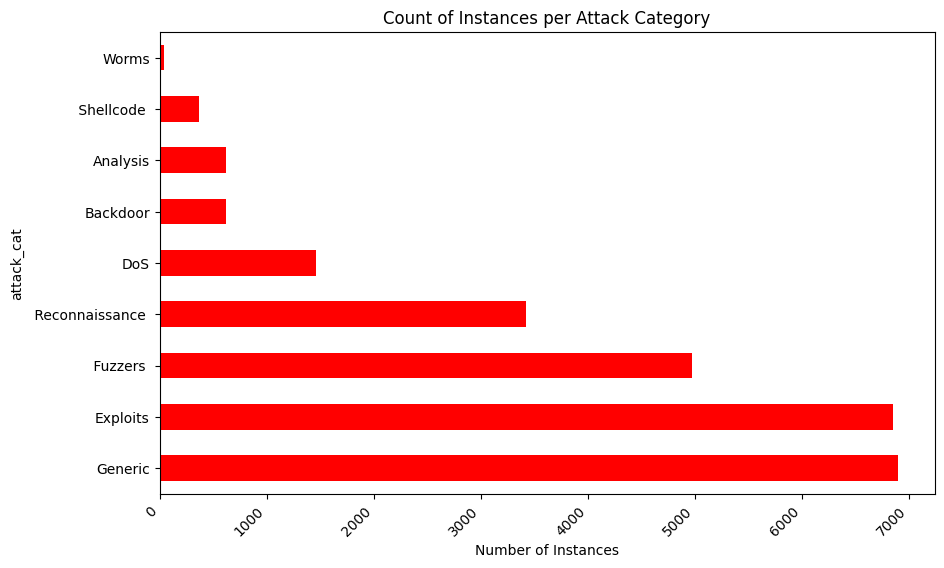

In [11]:
plt.figure(figsize=(10, 6))
attack_category_counts.plot(kind='barh', color='#FF0000')
plt.title('Count of Instances per Attack Category')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

In the dataset the *label* 0 indicating not an attack does not have a specific *attack category* feature. We need to add it in order to visualize clearly the distribuition of the *label*.

In [12]:
df.loc[df['Label'] == 0, 'attack_cat'] = 'Normal'

category_counts = df['attack_cat'].value_counts()
category_counts.to_frame().reset_index()

,attack_cat,count
0,Normal,281462
1,Generic,6894
2,Exploits,6851
3,Fuzzers,4970
4,Reconnaissance,3420
5,DoS,1465
6,Backdoor,623
7,Analysis,621
8,Shellcode,371
9,Worms,42


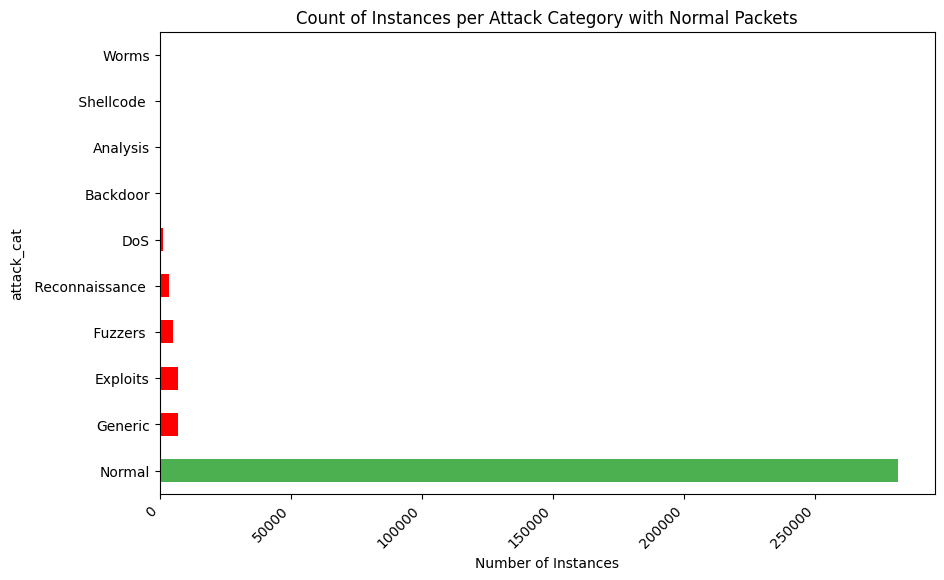

In [13]:
colors = ['#4CAF50' if category == 'Normal' else '#FF0000' for category in category_counts.index]

plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', color=colors)
plt.title('Count of Instances per Attack Category with Normal Packets')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

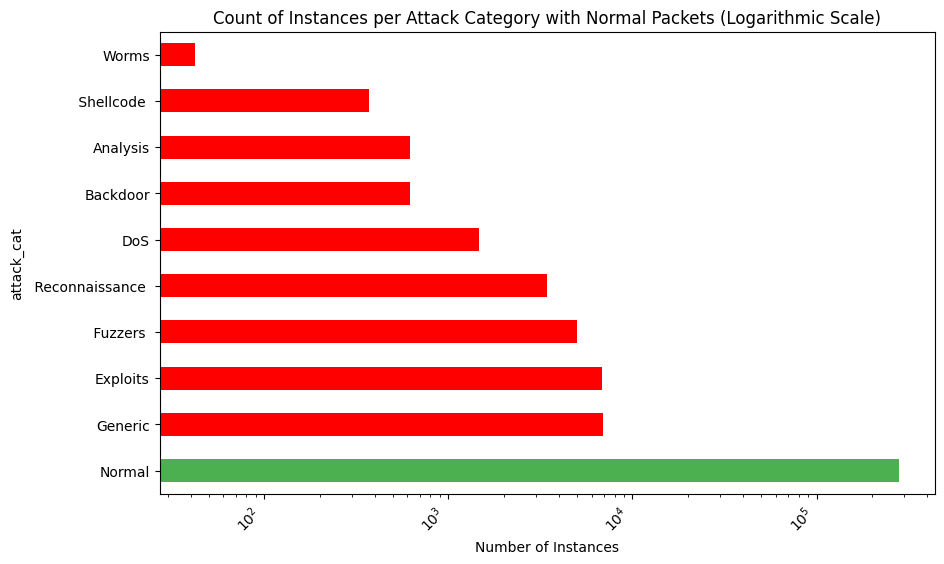

In [14]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', logx = True, color=colors)
plt.title('Count of Instances per Attack Category with Normal Packets (Logarithmic Scale)')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

Now our idea is map the *attack_cat* into 4 different category used commonly in intrusion detection:
- DoS: DoS, Worms
- U2R: Backdoor, Shellcode
- R2L: Exploits, Analysis
- Probe: Reconnaissance, Fuzzers, Generic
>[!NOTE]  
> *Worms* can be considered DoS attacks as they aim to duplicate and overcharge the network.  
> We classify *Generic* attacks under the Probe category, as they focus on information gathering and testing vulnerabilities (like *Brute Force Attack*).

In [15]:
df['attack_cat'] = df['attack_cat'].str.strip()

attack_categories = {
    'DoS': ['DoS', 'Worms'],
    'U2R': ['Backdoor', 'Shellcode'],
    'R2L': ['Exploits', 'Analysis'],
    'Probe': ['Reconnaissance', 'Fuzzers', 'Generic'],
    'Normal': ['Normal']
}

def assign_attack_group(attack_cat):
    for category, attacks in attack_categories.items():
        if attack_cat in attacks:
            return category
    return 'Unknown' 

df['attack_cat'] = df['attack_cat'].apply(assign_attack_group)


attack_group_count = df['attack_cat'].value_counts()
attack_group_count.to_frame().reset_index()




,attack_cat,count
0,Normal,281462
1,Probe,15284
2,R2L,7472
3,DoS,1507
4,U2R,994


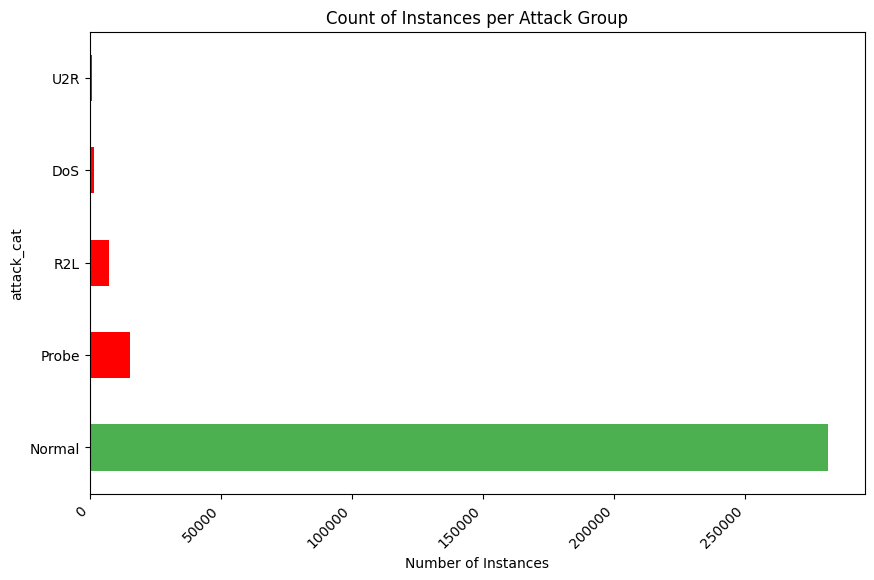

In [16]:
colors = ['#4CAF50', '#FF0000', '#FF0000', '#FF0000', '#FF0000']

plt.figure(figsize=(10, 6))
attack_group_count.plot(kind='barh' , color=colors)
plt.title('Count of Instances per Attack Group')
plt.xlabel('Number of Instances')
plt.ylabel('attack_cat')
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
df.head(10)

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,...,,2,2,7,4,1,1,3,Normal,0
1,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,...,,3,1,4,4,1,1,1,Normal,0
2,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,...,,3,5,2,7,1,1,4,Normal,0
3,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,...,,1,1,4,7,1,1,3,Normal,0
4,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,...,,2,5,2,1,1,1,2,Normal,0
5,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,...,,9,7,2,3,2,1,6,Normal,0
6,175.45.176.0,49582,149.171.126.12,80,tcp,FIN,0.189983,13304,268,254,...,,1,1,1,1,1,1,1,R2L,1
7,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,Probe,1
8,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,R2L,1
11,175.45.176.1,0,149.171.126.11,0,sctp,INT,0.000009,440,0,254,...,,1,1,1,1,1,1,2,U2R,1


As we can see now the dataset contains 4 categories for *attacks* and 1 for *benign* packets.  
This could led to proceed in 2 different ways:
- Balance the dataset using SMOTE. Be carefull to make both *oversampling* for *malicious* category and *undersampling* for *benign* one. This because the dataset is very **unbalanced** and the traformation made by using only *oversampling* will probably *broke* the dataset, because passing from *25k* to *281k* is a **very strong trasformation**.
- Leave the dataset as it is and use *models* and *metrics* appropiated to an *unbalanced* dataset.

#### #TODO Use smote for make the dateset balanced or use model that works well with unbalnced data.

## Nominal Feature

In [18]:
column_categoric=[
    'proto', 'state', 'service', 'attack_cat', 'Label'
    ]

df_filtered = df[df['Label'] == 1] 
df_filtered_count = (df_filtered[column_categoric].value_counts().to_frame().reset_index().rename(columns={0: 'count'}).head(15))
df_filtered_count

,proto,state,service,attack_cat,Label,count
0,udp,INT,dns,Probe,1,5443
1,tcp,FIN,-,Probe,1,3982
2,tcp,FIN,http,R2L,1,3020
3,udp,INT,-,Probe,1,2662
4,tcp,FIN,-,R2L,1,1253
5,tcp,FIN,http,Probe,1,1220
6,tcp,FIN,smtp,R2L,1,1033
7,unas,INT,-,Probe,1,630
8,tcp,FIN,http,DoS,1,471
9,unas,INT,-,R2L,1,420


All the *udp* attack are in *INT state* and for *dns* service.  
Most common *tcp* attack are *Exploits* and *Fuzzers* but in the *FIN* state. the *http* is the most attacked service. 

### Analysis of IP and PORT attributes
Check if there is some correlation between ip, port and attack to know if this two attributes are relevant for our analysis.<br>
Starting from IP:

In [19]:
attacks_df = df[df['Label'] == 1]

In [20]:
print(f"Total number of unique source IPs in attacks: {attacks_df['srcip'].nunique()}")
srcip_counts = attacks_df['srcip'].value_counts()
srcip_counts.head(45).to_frame().T

Total number of unique source IPs in attacks: 4


srcip,175.45.176.0,175.45.176.1,175.45.176.2,175.45.176.3
count,8290,6937,5537,4493


In [21]:
print(f"Total number of unique destination IPs in attacks: {attacks_df['dstip'].nunique()}")
dstip_counts = attacks_df['dstip'].value_counts()
dstip_counts.head(45).to_frame().T

Total number of unique destination IPs in attacks: 10


dstip,149.171.126.14,149.171.126.17,149.171.126.10,149.171.126.11,149.171.126.15,149.171.126.13,149.171.126.16,149.171.126.12,149.171.126.19,149.171.126.18
count,4650,4630,4195,2028,2022,1629,1611,1552,1517,1423


Now look at port:

In [22]:
print(f"Total number of unique source ports in attacks: {attacks_df['sport'].nunique()}")
sport_counts = attacks_df['sport'].value_counts()
sport_counts.head(45).to_frame().T

Total number of unique source ports in attacks: 13859


sport,0,47439,1043,68,137,19350,64679,38624,800,5060,...,59138,3982,5699,64492,26804,46455,44497,27072,49545,58351
count,3716,2717,2691,35,34,19,18,11,9,8,...,4,4,4,4,4,4,4,4,4,4


In [23]:
print(f"Total number of unique source ports in attacks: {attacks_df['dsport'].nunique()}")
sport_counts = attacks_df['dsport'].value_counts()
sport_counts.head(45).to_frame().T

Total number of unique source ports in attacks: 1026


dsport,53,80,0,111,25,179,445,520,21,514,...,3050,548,5900,500,88,8088,2000,50000,7144,2103
count,5542,4733,3716,2340,1270,1110,954,867,472,464,...,11,11,10,9,9,9,9,9,8,8


In the UNSW-NB15 dataset, the simulated attacks always originate from the same source IP addresses and are directed towards the same destination IP addresses, as described in the paper (https://ieeexplore.ieee.org/abstract/document/7348942). Therefore, the attributes srcip (Source IP address), dstip (Destination IP address), and sport (Source port number) have limited relevance for attack classification therefore in our case (lab data) will only create an **enormous** BIAS. These attributes do not reflect the variability of IP addresses and source ports observable in a real network environment, making them less informative.
<br>
On the other hand, the attribute dport (Destination port number) could be important but redundant, as there are other attributes like proto (protocol) and service that more or less carry the same information. <br>

### Analysis of Stime and Ltime attributes 
The attributes Stime and Ltime, which represent the start timestamps and the end one of network events, are likely of low relevance for classifying attacks. These timestamps are specific to the moment of recording and do not follow deterministic patterns useful for distinguishing between normal traffic and attacks. Additionally, the connection duration (dur) makes these attributes redundant. We will probably not consider them in our initial model but will study them more thoroughly during the feature selection phase using the correlation matrix to confirm their irrelevance.  

#### #TODO Analize Stime and Ltime in features selection using correlation matrix in feature selction phase

## Identify Missing and Erroneus Values 

In [24]:
missing_values = df.isnull().sum()
missing_values_filtered = missing_values[missing_values > 0]

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

print("Missing values in each column:")
missing_values_filtered.to_frame().T

Missing values in each column:


,ct_flw_http_mthd,is_ftp_login
0,273700,300350


The unique colums with missing value are *ct_flw_http_mthd* and *is_ftp_login*.

In [25]:
rows_with_missing_values = df[df.isnull().any(axis=1)]
print("\nNumber of rows with at least one missing values in one column:", len(rows_with_missing_values))


Number of rows with at least one missing values in one column: 306719


In [26]:
total_rows = df.shape[0]
print(f"Total number of rows in the dataset: {total_rows}")

Total number of rows in the dataset: 306719


> [!Note]
> We have at least one missing value for row.

### ct_flw_http_mthd and *service* attributes analysis

Probably the *ct_flw_http_mthd* (number of flows that has methods such as Get and Post in http service) are directly linked with *service* attribute:

In [27]:
missing_values = df[df['ct_flw_http_mthd'].isnull()]

missing_values_by_service = missing_values['service'].value_counts()

print("Number of missing values in ct_flw_http_mthd column for each service:")
missing_values_by_service.to_frame().T

Number of missing values in ct_flw_http_mthd column for each service:


service,-,dns,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,167857,61481,18228,12140,6842,6692,363,30,26,25,9,7


if *ct_flw_http_mthd* is null no *http* in the column service is found. BUT

In [28]:
http_count = (df['service'] == 'http').sum()
other_count = total_rows - http_count

ct_flw_count = df['ct_flw_http_mthd'].notna().sum()

print(f"Number of rows without service 'http': {other_count}")
print(f"Number of rows with service 'http': {http_count}")
print(f"Number of rows with 'ct_flw_http_mthd': {ct_flw_count}")

Number of rows without service 'http': 273942
Number of rows with service 'http': 32777
Number of rows with 'ct_flw_http_mthd': 33019


The number of raws without service 'http' is not really the number of raws missing con the attribute *ct_flw_http_mthd*.  
Indeed the the number of raws not null of *ct_flw_http_mthd* is higher to the one with service *http* so some other service as *http* and this coul be an error in the dataset. The difference is **242**.

In [29]:
ct_flow_notna_values = df[df['ct_flw_http_mthd'].notna()]

ct_flow_notna_values_no_http = ct_flow_notna_values[ct_flow_notna_values['service'] != 'http']

service_counts = ct_flow_notna_values_no_http['service'].value_counts()

service_counts.to_frame().T

service,-
count,242


So there is an **error** and those service (-) should be **http**.

BEFORE

In [30]:
df['service'].value_counts().to_frame().T

service,-,dns,http,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,168099,61481,32777,18228,12140,6842,6692,363,30,26,25,9,7


AFTER

In [31]:
df.loc[ct_flow_notna_values_no_http.index, 'service'] = 'http'

df['service'].value_counts().to_frame().T

service,-,dns,http,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,167857,61481,33019,18228,12140,6842,6692,363,30,26,25,9,7


Now since the number of raws not null of the attribute *ct_flw_http_mthd* is equal to the packets with attribute *service* (33019) the attributes are correct.  
Regarding the other services, they cannot have HTTP methods.  

In [32]:
min_value = ct_flow_notna_values['ct_flw_http_mthd'].min()
max_value = ct_flow_notna_values['ct_flw_http_mthd'].max()

print(f"Numerical range for 'ct_flw_http_mthd': Min = {min_value}, Max = {max_value}")


Numerical range for 'ct_flw_http_mthd': Min = 1.0, Max = 9.0


Since the attribute *ct_flw_http_mthd* is a numerical value with those range, we can set the ct_flw_http_mthd value to 0 for rows where the service is one of these non-HTTP. This adjustment will be made during the preprocessing phase.

In [33]:
unspecified_service_rows = df[df['service'] == '-']
print(f"Number of rows with unspecified service: {len(unspecified_service_rows)}")

Number of rows with unspecified service: 167857


We can observe that there isn't missing value for the attribute *ct_flw_http_mthd* when the *service* is *http*.

As we can see the attribute *service* as values '-' and this because those values are Missing. 


Now check if service erroneus value are linked with the attacks to the network:

In [34]:
unspecified_service_rows = df[df['service'] == '-']
total_unspecified = len(unspecified_service_rows)

attack_rows = unspecified_service_rows[unspecified_service_rows['Label'] == 1]
total_attacks = len(attack_rows)

percentage_attack = (total_attacks / total_unspecified) * 100

print(f'Total Attacks with Unspecified Service: {total_attacks}')
print(f'Percentage of Attacks that have unspecified service:  {percentage_attack}')


Total Attacks with Unspecified Service: 12342
Percentage of Attacks that have unspecified service:  7.35268710866988


Since several instances representing attacks have the value '-' in the service column, it would not be advisable to remove those rows. Therefore, as mentioned above, we will substitute the value in pre-processing phase.

### is_ftp_login attribute analysis

Probably also the is_ftp_login (if the ftp session is accessed by user and password then 1 else 0) are directly linked with service attribute:

In [35]:
unspecified_is_ftp_login_rows = df[df['is_ftp_login'].isnull()]
print(f"Number of rows with unspecified is_ftp_login: {len(unspecified_is_ftp_login_rows)}")

Number of rows with unspecified is_ftp_login: 300350


In [36]:
missing_values = df[df['is_ftp_login'].isnull()]

missing_values_by_service = missing_values['service'].value_counts()

print("Number of missing values in is_ftp_login column for each service:")
missing_values_by_service.to_frame().T

Number of missing values in is_ftp_login column for each service:


service,-,dns,http,ftp-data,smtp,ssh,pop3,ftp,ssl,snmp,dhcp,radius,irc
count,167857,61481,33019,18228,12140,6842,363,323,30,26,25,9,7


The value should be binary, but we have different integer values. Look at the numbers.

In [37]:
is_ftp_login_df = df['is_ftp_login'].value_counts()
is_ftp_login_df.to_frame().T

is_ftp_login,1.0,4.0,2.0
count,6335,27,7


In [38]:
non_missing_is_ftp_login_rows = df[df['is_ftp_login'].notnull()]
non_missing_is_ftp_login_rows_ftp = non_missing_is_ftp_login_rows[non_missing_is_ftp_login_rows['service'] == 'ftp']
service_count = non_missing_is_ftp_login_rows_ftp['service'].value_counts()
service_count.to_frame().T

service,ftp
count,6369


We can conclude that all non-missing values of is_ftp_login are within the ftp service. Therefore, during the preprocessing phase, we can substitute all positive values for this attribute with 1 and set the missing values to 0.  

The *is_ftp_login* attributes probably was only set to a value if it was present and was missing in all the other cases.

In [39]:
non_missing_is_ftp_login_null = df[df['is_ftp_login'].isnull()]

non_missing_is_ftp_login_rows_attack = non_missing_is_ftp_login_null[(non_missing_is_ftp_login_null['Label'] == 1) & (non_missing_is_ftp_login_null['service'] == 'ftp')]
service_count = non_missing_is_ftp_login_rows_attack['Label'].value_counts()

print("Number of attacks with missing is_ftp_login and service as ftp:")
service_count.to_frame().T

Number of attacks with missing is_ftp_login and service as ftp:


Label,1
count,171


Our first thought was to eliminate the column as it can say the same things for classifying an attack to *ftp*. But this is not true, indeed there are some missing values for *is_ftp_login* in the *ftp* service that belongs to the class label *1* (attack). So eliminating the column will only result in a loss of information.  
There are in *ftp* some attacks that does not depend on the fact that the user is accessed or not (*is_ftp_login*).

### ct_ftp_cmd attribute analysis
Numbers of flows that has a command in ftp session.

In [40]:
ct_ftp_cmd_df = df['ct_ftp_cmd'].value_counts()
ct_ftp_cmd_df.to_frame().T


ct_ftp_cmd,,1,4,2
count,300350,6335,27,7


In [41]:
non_empty_ct_ftp_cmd_rows = df[df['ct_ftp_cmd'] != ' ']
non_empty_ct_ftp_cmd_rows_ftp = non_empty_ct_ftp_cmd_rows[non_empty_ct_ftp_cmd_rows['service'] == 'ftp']
service_count = non_empty_ct_ftp_cmd_rows_ftp['service'].value_counts()
service_count.to_frame().T

service,ftp
count,6369


We observe that all rows with a 'ct_ftp_cmd' value different from null have 'ftp' as the 'service' attribute. Therefore, we can substitute the null values with 0. <br>

In [42]:
df['ct_ftp_cmd'].value_counts().to_frame().T

ct_ftp_cmd,,1,4,2
count,300350,6335,27,7


In [43]:
df['is_ftp_login'].value_counts().to_frame().T

is_ftp_login,1.0,4.0,2.0
count,6335,27,7


In [44]:
test = df
test['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').astype('Int64')

non_zero_rows = test[(test['is_ftp_login'].notna()) & (test['ct_ftp_cmd'] != ' ')]

are_values_equal = (non_zero_rows['is_ftp_login'] == non_zero_rows['ct_ftp_cmd']).all()

are_values_equal

np.True_

Indeed analysing those two attributes *is_ftp_login*, *ct_ftp_cmd* we notice that they are equals in number, in values and in raws.  
Probably one of them is wrong, even if not anyway the attributes together are redundant. So we decided to remove *is_ftp_login* that is probably the erroneous value beacause the documentation says that it should be a *Bynary* tipe.

#### #TODO Remove the columns *is_ftp_login* because is redundant.

Regarding all the consideration made for the attribute *is_ftp_login* they remain still valid because we can just apply that to the attribute *ct_ftp_cmd* indeed they are actually the same. 

## Overall overview of the values in the dataset

### Nominal Value

In [45]:
string_columns = df.select_dtypes(include=['object']).columns
print("Column with string values:")
string_columns.to_list()

Column with string values:


['srcip', 'dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']

In [46]:
unique_values_count = df[string_columns].nunique()
print("\nNumber of unique values in each nominal column:")
unique_values_count.to_frame().T


Number of unique values in each nominal column:


,srcip,dstip,dsport,proto,state,service,attack_cat
0,38,43,48861,133,14,13,5


In [47]:
print("\nUnique values in each nominal column:")
for column in string_columns:
    unique_values = df[column].unique()
    print(f"\n{column}:")
    print(unique_values)


Unique values in each nominal column:

srcip:
['59.166.0.9' '59.166.0.2' '59.166.0.8' '59.166.0.0' '175.45.176.0'
 '175.45.176.1' '59.166.0.6' '59.166.0.1' '59.166.0.3' '59.166.0.5'
 '10.40.182.3' '10.40.170.2' '175.45.176.2' '59.166.0.4' '59.166.0.7'
 '175.45.176.3' '10.40.85.30' '10.40.182.1' '10.40.85.10' '10.40.85.1'
 '149.171.126.11' '149.171.126.12' '10.40.182.6' '149.171.126.14'
 '149.171.126.13' '149.171.126.8' '149.171.126.17' '149.171.126.18'
 '149.171.126.15' '149.171.126.19' '149.171.126.5' '149.171.126.6'
 '149.171.126.4' '149.171.126.1' '149.171.126.2' '149.171.126.0'
 '149.171.126.10' '149.171.126.7']

dstip:
['149.171.126.7' '149.171.126.2' '149.171.126.4' '149.171.126.8'
 '149.171.126.12' '149.171.126.11' '149.171.126.6' '149.171.126.0'
 '149.171.126.1' '149.171.126.5' '149.171.126.3' '149.171.126.9'
 '10.40.182.3' '10.40.170.2' '149.171.126.18' '149.171.126.13'
 '149.171.126.14' '149.171.126.10' '149.171.126.16' '149.171.126.19'
 '149.171.126.17' '149.171.126.15' '10

### Numerical values

In [48]:
numeric_columns = df.select_dtypes(include=['number']).columns
print("Columns with numeric values:")
print(numeric_columns.to_list())

Columns with numeric values:
['sport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label']


In [49]:
unique_values_count = df[numeric_columns].nunique()
print("\nNumber of unique values in each numerical column:")
unique_values_count.to_frame().T


Number of unique values in each numerical column:


,sport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
0,63728,142812,4572,3886,11,7,245,283,198260,198441,404,336,8,15,211584,211509,1230,1191,7,1386,213096,218471,11773,11771,184878,183900,22067,20917,19509,2,5,5,3,3,61,61,57,57,57,46,61,2


In [50]:
print("\nUnique values in each numerical column:")
for column in numeric_columns:
    unique_values = df[column].unique()
    print(f"\n{column}:")
    print(unique_values)


Unique values in each numerical column:

sport:
[ 7045  9685  1421 ... 48486 18826 45604]

dur:
[2.018860e-01 5.864748e+00 1.391000e-03 ... 2.200934e+00 5.649980e-01
 8.730600e-02]

sbytes:
[ 37552  19410    146 ... 269883   3498  14106]

dbytes:
[   3380 1087890     178 ...   60216  166054  772406]

sttl:
[ 31 254   0  62  63   1 255  60  64 252  29]

dttl:
[ 29 252   0  60 254  31  30]

sloss:
[  18    2    0   19   38    6    3    7   55   52   78    1   11    4
    9   30    8   21   31   13   17  999   54   53   24    5   10  102
   32   51  331   61  154   34  171   35   15  167   42   12   43  355
   22   28   77   94   50   16   29  186   20   23  149   33   48   65
   14   27   36   47  332   41  408  146  286   93  183   39 2688  619
   70 3129   87 3307   72  175 2401  125  120   73   76  130  131   44
  166   82  352  128  144  189  808   79   26 1111   25  747  271   49
 2623  932   37   40   90  279   45   68  552  280 2468   81  240   71
   56  177 3624 4158  238 3607  

# Data Pre-Processing

Already done:
- Delete duplicates. 
- Add value in *attack_cat* for Normal packets.
- Substitued the attribute *attack_cat* with new macro-categories.
- Resolved incongruence between attributes *ct_flw_http_mthd* and *service*.

## Data Cleaning

### Remove IP and Ports.

Delete attributes for source and destination *ip addresses* and *ports* (*srcip*, *dstip*, *sport*, *dsport*). 

In [51]:
df = df.drop(columns=['srcip', 'dstip', 'sport', 'dsport'])

df.head(5)

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,tcp,FIN,0.201886,37552,3380,31,29,18,8,smtp,1.459438e+06,1.307669e+05,52,42,255,255,1422136554,3572668484,722,80,0,0,456.043567,15.530109,1424250009,1424250009,3.943843,4.912488,0.000590,0.000473,0.000117,0,0,NaN,NaN,<NA>,2,2,7,4,1,1,3,Normal,0
1,tcp,FIN,5.864748,19410,1087890,31,29,2,370,http,2.640454e+04,1.481983e+06,364,746,255,255,389619597,394688654,53,1458,1,0,1031.366423,690.219581,1424250003,1424250009,16.155447,7.871279,0.000771,0.000638,0.000133,0,0,1.0,NaN,<NA>,3,1,4,4,1,1,1,Normal,0
2,udp,CON,0.001391,146,178,31,29,0,0,dns,4.198418e+05,5.118620e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.002000,0.000000,0.000000,0.000000,0,0,NaN,NaN,<NA>,3,5,2,7,1,1,4,Normal,0
3,tcp,FIN,0.053948,37812,3380,31,29,19,8,smtp,5.503374e+06,4.893601e+05,54,42,255,255,4047523379,1903327524,700,80,0,0,65.909688,3.155258,1424250009,1424250009,1.011547,1.302561,0.000674,0.000540,0.000134,0,0,NaN,NaN,<NA>,1,1,4,7,1,1,3,Normal,0
4,udp,CON,0.000953,146,178,31,29,0,0,dns,6.128017e+05,7.471144e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.004000,0.000000,0.000000,0.000000,0,0,NaN,NaN,<NA>,2,5,2,1,1,1,2,Normal,0


### Missing values in attribute *service*

Substitute '-' with 'missing' in the attribute *service*

In [52]:
service_missing_value = df[df['service'] == '-']

df.loc[service_missing_value.index, 'service'] = 'missing'

df['service'].value_counts().to_frame().T

service,missing,dns,http,ftp-data,smtp,ssh,ftp,pop3,ssl,snmp,dhcp,radius,irc
count,167857,61481,33019,18228,12140,6842,6692,363,30,26,25,9,7


### Missing values in attribute *ct_flw_http_mthd*

Substitute missing values with *0.0* in the attribute *ct_flw_http_mthd*.

In [53]:
ct_flow_missing_value = df[df['ct_flw_http_mthd'].isnull()]

df.loc[ct_flow_missing_value.index, 'ct_flw_http_mthd'] = 0.0

df['ct_flw_http_mthd'].value_counts().to_frame().T

ct_flw_http_mthd,0.0,1.0,4.0,2.0,9.0,6.0
count,273700,32287,623,84,21,4


### Missing values in attribute *ct_ftp_cmd* 
As the documentations says this attribute should be *Integer* but it's a *string*. Firstly we will convert values in string and then fill the *Missing Values*

In [54]:
df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').astype('Int64')

ct_ftp_missing_value = df[df['ct_ftp_cmd'].isnull()]

df.loc[ct_ftp_missing_value.index, 'ct_ftp_cmd'] = 0.0

df['ct_ftp_cmd'].value_counts().to_frame().T

ct_ftp_cmd,0,1,4,2
count,300350,6335,27,7


### Remove *is_ftp_login* attribute

In [55]:
df = df.drop(columns=['is_ftp_login'])

df.head(5)

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,tcp,FIN,0.201886,37552,3380,31,29,18,8,smtp,1.459438e+06,1.307669e+05,52,42,255,255,1422136554,3572668484,722,80,0,0,456.043567,15.530109,1424250009,1424250009,3.943843,4.912488,0.000590,0.000473,0.000117,0,0,0.0,0,2,2,7,4,1,1,3,Normal,0
1,tcp,FIN,5.864748,19410,1087890,31,29,2,370,http,2.640454e+04,1.481983e+06,364,746,255,255,389619597,394688654,53,1458,1,0,1031.366423,690.219581,1424250003,1424250009,16.155447,7.871279,0.000771,0.000638,0.000133,0,0,1.0,0,3,1,4,4,1,1,1,Normal,0
2,udp,CON,0.001391,146,178,31,29,0,0,dns,4.198418e+05,5.118620e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.002000,0.000000,0.000000,0.000000,0,0,0.0,0,3,5,2,7,1,1,4,Normal,0
3,tcp,FIN,0.053948,37812,3380,31,29,19,8,smtp,5.503374e+06,4.893601e+05,54,42,255,255,4047523379,1903327524,700,80,0,0,65.909688,3.155258,1424250009,1424250009,1.011547,1.302561,0.000674,0.000540,0.000134,0,0,0.0,0,1,1,4,7,1,1,3,Normal,0
4,udp,CON,0.000953,146,178,31,29,0,0,dns,6.128017e+05,7.471144e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.004000,0.000000,0.000000,0.000000,0,0,0.0,0,2,5,2,1,1,1,2,Normal,0


Drop duplicate again because we removed some columns.

In [56]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

## Data Preparation

Create the trainig test dataframe. We don't need Label because we are classifying with *attack_cat*

In [57]:
train_Y = df['attack_cat']
train_x_raw = df.drop(['attack_cat','Label'], axis=1)

Update colums lists.

In [58]:
string_columns = train_x_raw.select_dtypes(include=['object']).columns
numeric_columns = train_x_raw.select_dtypes(include=['number']).columns

string_columns.to_list()

['proto', 'state', 'service']

Use *pd.get_dummies* method because **SMOTE** and **Logistc Regression** Classifier cannot handle nominal columns.

In [59]:
train_x = pd.get_dummies(train_x_raw, columns=string_columns, drop_first=True)

dummy_variables = list(set(train_x)-set(train_x_raw))

print(dummy_variables)

['proto_ipip', 'proto_sep', 'proto_egp', 'proto_uti', 'proto_l2tp', 'service_ssl', 'proto_rtp', 'proto_ipcv', 'proto_tp++', 'proto_visa', 'proto_cpnx', 'proto_ipx-n-ip', 'proto_leaf-2', 'proto_nsfnet-igp', 'proto_sprite-rpc', 'proto_igmp', 'proto_rsvp', 'proto_fire', 'proto_smp', 'proto_gmtp', 'proto_nvp', 'proto_bna', 'proto_stp', 'service_ftp', 'state_INT', 'proto_st2', 'proto_trunk-1', 'proto_irtp', 'proto_iplt', 'proto_ax.25', 'service_snmp', 'proto_micp', 'state_TXD', 'proto_secure-vmtp', 'proto_vmtp', 'proto_ospf', 'proto_br-sat-mon', 'proto_pipe', 'proto_i-nlsp', 'proto_pim', 'proto_rdp', 'proto_pgm', 'proto_ipv6-no', 'proto_mtp', 'proto_idpr', 'proto_mfe-nsp', 'proto_cphb', 'state_CON', 'service_irc', 'service_pop3', 'proto_ipv6', 'proto_tcf', 'proto_sun-nd', 'proto_ptp', 'proto_pup', 'proto_encap', 'proto_sctp', 'proto_dgp', 'state_MAS', 'proto_ip', 'proto_icmp', 'state_ECR', 'proto_mobile', 'proto_xns-idp', 'state_REQ', 'proto_udp', 'proto_isis', 'proto_mux', 'proto_xtp', 'se

### Balancing the dataset

In [60]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [61]:
train_x = train_x.astype('float64')

print('Labels with NO sampler:')
train_Y.value_counts().to_frame().T

Labels with NO sampler:


attack_cat,Normal,Probe,R2L,DoS,U2R
count,281128,14149,6971,1506,994


In [62]:
sampling_strategy = {"Normal":100000} 
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

train_x_under, train_Y_under = under_sampler.fit_resample(train_x, train_Y)

train_Y_under.value_counts().to_frame().T

attack_cat,Normal,Probe,R2L,DoS,U2R
count,100000,14149,6971,1506,994


In [63]:
smote = SMOTE(random_state=42)

train_x_balanced_100k, train_Y_balanced_100k = smote.fit_resample(train_x_under, train_Y_under)

train_Y_balanced_100k.value_counts().to_frame().T

attack_cat,DoS,Normal,Probe,R2L,U2R
count,100000,100000,100000,100000,100000


In [64]:
sampling_strategy = {"Normal":15000} 
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

train_x_under, train_Y_under = under_sampler.fit_resample(train_x, train_Y)

train_Y_under.value_counts().to_frame().T

attack_cat,Normal,Probe,R2L,DoS,U2R
count,15000,14149,6971,1506,994


In [65]:
smote = SMOTE(random_state=42)

train_x_balanced_15k, train_Y_balanced_15k = smote.fit_resample(train_x_under, train_Y_under)

train_Y_balanced_15k.value_counts().to_frame().T

attack_cat,DoS,Normal,Probe,R2L,U2R
count,15000,15000,15000,15000,15000


### Feature Selection

Using Decision tree to sort features for importance.

In [66]:
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier(random_state=42)

model.fit(train_x_balanced_100k, train_Y_balanced_100k)

importances = pd.Series(model.feature_importances_, index=train_x_balanced_100k.columns)

In [ ]:
selected_features = importances.sort_values(ascending=False).reset_index()
selected_features.columns = ['Feature', 'Importance']


selected_features_top_25 = selected_features.head(25)

train_x_selected = train_x_balanced_100k[selected_features_top_25['Feature'].values]


train_x_selected.head(5)

,sttl,sbytes,ct_srv_dst,ct_dst_src_ltm,ct_src_ltm,stcpb,dtcpb,service_missing,dloss,ct_srv_src,Sload,smeansz,proto_udp,ct_dst_ltm,ct_src_dport_ltm,Dpkts,Djit,res_bdy_len,ct_dst_sport_ltm,ackdat,Sintpkt,synack,dbytes,Sjit,Stime
0,254.0,440.0,1.0,2.0,1.0,0.000000e+00,0.000000e+00,1.0,0.0,1.0,1.955556e+08,220.0,0.0,1.0,1.0,0.0,0.000000,0.0,1.0,0.000000,0.009000,0.000000,0.0,0.000000,1.424250e+09
1,254.0,790.0,1.0,1.0,1.0,2.703804e+09,6.000794e+08,0.0,1.0,2.0,2.868700e+04,79.0,0.0,1.0,1.0,6.0,64.709930,0.0,1.0,0.045983,20.461889,0.008850,268.0,1095.122916,1.424250e+09
2,254.0,7058.0,1.0,1.0,1.0,3.444304e+08,1.982150e+09,0.0,13.0,2.0,3.911018e+04,221.0,0.0,1.0,1.0,30.0,56.216523,98.0,1.0,0.048451,45.119838,0.009852,9826.0,2161.334373,1.424250e+09
3,254.0,2858.0,1.0,1.0,1.0,0.000000e+00,0.000000e+00,1.0,0.0,1.0,1.361521e+04,159.0,0.0,1.0,1.0,0.0,0.000000,0.0,1.0,0.000000,93.321234,0.000000,0.0,171.851906,1.424250e+09
4,62.0,1060.0,1.0,1.0,1.0,1.063415e+09,4.143685e+09,0.0,25.0,1.0,2.361262e+04,66.0,0.0,1.0,1.0,54.0,851.106385,32166.0,1.0,0.044213,22.451267,0.005841,67045.0,1167.055283,1.424250e+09


# Data Processing

## Logistic Regression

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

### Unbalanced

Split the data into train and test:

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    train_x, train_Y, test_size=0.30, random_state=21)

Scale the data:

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create and train the logistic regression model and make prediction:

In [71]:
clf = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

Evaluation metrics:

In [72]:
print("--------------------------")
print(f"Accuracy = {accuracy_score(y_pred, y_test)}")
print("--------------------------")
print("Classification Report:\n", classification_report(y_test, y_pred))

--------------------------
Accuracy = 0.9650861361771944
--------------------------
Classification Report:
               precision    recall  f1-score   support

         DoS       0.20      0.07      0.11       469
      Normal       0.99      0.99      0.99     84339
       Probe       0.69      0.78      0.73      4216
         R2L       0.68      0.67      0.68      2112
         U2R       0.10      0.04      0.06       289

    accuracy                           0.97     91425
   macro avg       0.53      0.51      0.51     91425
weighted avg       0.96      0.97      0.96     91425



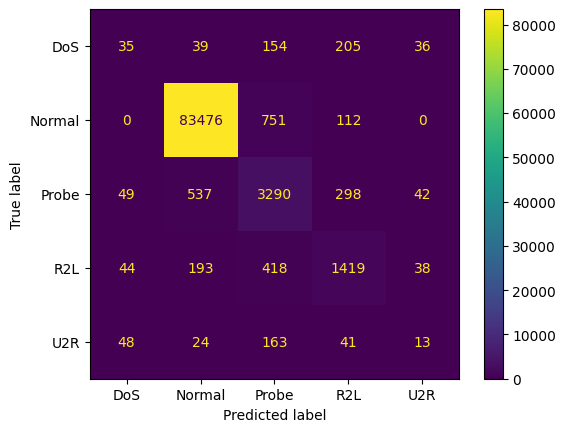

In [73]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)

Extracting Coefficients:

In [74]:
coefficients = clf.coef_[0]
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

coeff_df.T

,33,4,189,16,1,5,10,9,151,11,12,175,187,37,2,194,186,185,174,6,158,36,26,19,24,29,34,179,192,15,25,8,190,184,3,23,116,135,193,32,178,17,171,38,55,110,105,106,74,128,112,165,102,133,18,44,114,52,61,138,163,167,108,109,111,56,157,84,41,39,90,57,67,136,126,72,76,118,195,91,148,48,152,81,42,164,107,70,137,100,98,85,69,120,149,64,62,59,132,155,45,104,46,60,43,54,93,50,96,77,58,95,14,94,154,49,142,51,123,97,160,168,40,88,63,92,161,115,127,82,153,53,101,121,162,73,156,146,83,65,125,119,103,169,134,27,87,140,150,170,147,130,131,113,191,141,117,89,145,159,68,75,172,13,66,79,86,124,35,0,122,166,99,22,78,143,20,21,7,31,28,188,30,177,139,47,182,180,181,176,183,71,144,80,129,173
Feature,ct_srv_dst,dttl,service_missing,dmeansz,sbytes,sloss,Dpkts,Spkts,proto_tcp,swin,dwin,state_INT,service_http,ct_dst_sport_ltm,dbytes,service_ssh,service_ftp-data,service_ftp,state_FIN,dloss,proto_unas,ct_src_dport_ltm,synack,Sjit,Dintpkt,ct_state_ttl,ct_dst_ltm,state_RST,service_smtp,smeansz,tcprtt,Dload,service_pop3,service_dns,sttl,Sintpkt,proto_ospf,proto_sctp,service_snmp,ct_srv_src,state_REQ,trans_depth,state_CON,ct_dst_src_ltm,proto_crtp,proto_mtp,proto_merit-inp,proto_mfe-nsp,proto_ib,proto_rsvp,proto_narp,proto_wb-mon,proto_larp,proto_sccopmce,res_bdy_len,proto_arp,proto_nsfnet-igp,proto_compaq-peer,proto_egp,proto_sep,proto_vrrp,proto_xnet,proto_micp,proto_mobile,proto_mux,proto_crudp,proto_udp,proto_ipcomp,proto_any,proto_a/n,proto_ipv6,proto_dcn,proto_fire,proto_sdrp,proto_qnx,proto_i-nlsp,proto_idpr,proto_pim,service_ssl,proto_ipv6-frag,proto_sun-nd,proto_br-sat-mon,proto_tlsp,proto_igp,proto_argus,proto_wb-expak,proto_mhrp,proto_gre,proto_secure-vmtp,proto_kryptolan,proto_iso-ip,proto_ipcv,proto_gmtp,proto_pnni,proto_swipe,proto_encap,proto_eigrp,proto_ddx,proto_sat-mon,proto_trunk-2,proto_ax.25,proto_leaf-2,proto_bbn-rcc,proto_dgp,proto_aris,proto_cpnx,proto_ipv6-opts,proto_cftp,proto_irtp,proto_idpr-cmtp,proto_ddp,proto_ipx-n-ip,dtcpb,proto_ipv6-route,proto_trunk-1,proto_cbt,proto_snp,proto_chaos,proto_ptp,proto_isis,proto_vines,proto_xns-idp,proto_aes-sp3-d,proto_ipnip,proto_emcon,proto_ipv6-no,proto_visa,proto_nvp,proto_rdp,proto_il,proto_tp++,proto_cphb,proto_l2tp,proto_pri-enc,proto_vmtp,proto_iatp,proto_ttp,proto_st2,proto_ip,proto_etherip,proto_pvp,proto_pipe,proto_leaf-1,proto_xtp,proto_scps,ackdat,proto_iplt,proto_sm,proto_tcf,proto_zero,proto_stp,proto_rvd,proto_sat-expak,proto_netblt,service_radius,proto_smp,proto_pgm,proto_ippc,proto_srp,proto_uti,proto_ggp,proto_icmp,state_ECO,stcpb,proto_fc,proto_ifmp,proto_ipip,proto_pup,ct_src_ltm,dur,proto_prm,proto_wsn,proto_iso-tp4,Ltime,proto_idrp,proto_sprite-rpc,Djit,Stime,Sload,ct_ftp_cmd,is_sm_ips_ports,service_irc,ct_flw_http_mthd,state_PAR,proto_skip,proto_bna,state_URN,state_TST,state_TXD,state_MAS,state_no,proto_hmp,proto_sps,proto_igmp,proto_rtp,state_ECR
Coefficient,-1.998851,1.667587,-1.437222,1.274946,-1.254868,1.045545,0.83242,0.671094,-0.658078,-0.651095,-0.559332,0.553402,-0.550347,0.53068,-0.464438,-0.422403,-0.37317,-0.33468,-0.315145,-0.276175,0.248548,0.226829,-0.216357,0.215595,0.174423,0.166033,-0.14272,0.140351,0.135997,0.135995,-0.135727,-0.109925,0.108968,-0.096953,-0.094952,-0.089276,0.088402,0.076743,0.067802,-0.064321,0.06288,0.058935,0.056046,0.054829,0.046004,0.04496,0.044367,0.043999,0.038691,0.038508,0.03837,0.038085,0.037843,0.037698,0.037527,0.037277,0.037247,0.036517,0.036299,0.035747,0.035663,0.035442,0.035435,0.035384,0.035251,0.035165,-0.034996,0.034101,0.03392,0.031747,0.031526,0.031503,0.031284,0.031057,0.030514,0.030511,0.030488,0.030449,0.030278,0.030264,0.029943,0.029943,0.029876,0.029686,0.029426,0.029201,0.028876,0.028758,0.028756,0.028641,0.028384,0.028341,0.02831,0.028306,0.028198,0.028065,0.027949,0.027714,0.027678,0.027315,0.027283,0.027203,0.026805,0.026547,0.026416,0.026212,0.026172,0.026123,0.026033,0.026016,0.026003,0.025932,0.025784,0.025605,0.025521,0.025464,0.025404,0.025106,0.025087,0.025085,0.025077,0.024886,0.024827,0.024641,0.024613,

Accuracy: The model achieves an accuracy of 96.3%, but this metric is misleading due to class imbalance. The "Normal" class dominates, leading to high performance for this class but poor detection of attack classes.

Class Imbalance: The model performs exceptionally well on the "Normal" class but struggles with attack classes, especially DoS and U2R, showing very low recall and F1-scores for these categories (near zero for U2R).

Next Steps:

- Class Balancing: Addressing class imbalance through oversampling or undersampling of minority classes will improve performance on attack detection.
- Feature Selection: Not use all features but only top features based on large absolute coefficients

Now use the balanced dataframe:
- train_Y_balanced_15k
- train_Y_balanced_100k

### Training test Balanced with 100k for all categories (*train_Y_balanced_100k*)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    train_x_balanced_100k, train_Y_balanced_100k, test_size=0.30, random_state=21)

Scale the data:

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create and train the logistic regression model and make prediction:

In [77]:
clf = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

In [78]:
print("--------------------------")
print(f"Accuracy = {accuracy_score(y_pred, y_test)}")
print("--------------------------")
print("Classification Report:\n", classification_report(y_test, y_pred))

--------------------------
Accuracy = 0.6766733333333333
--------------------------
Classification Report:
               precision    recall  f1-score   support

         DoS       0.43      0.19      0.27     29913
      Normal       0.97      0.97      0.97     29949
       Probe       0.75      0.68      0.72     29826
         R2L       0.63      0.67      0.65     30102
         U2R       0.55      0.87      0.68     30210

    accuracy                           0.68    150000
   macro avg       0.67      0.68      0.65    150000
weighted avg       0.67      0.68      0.65    150000



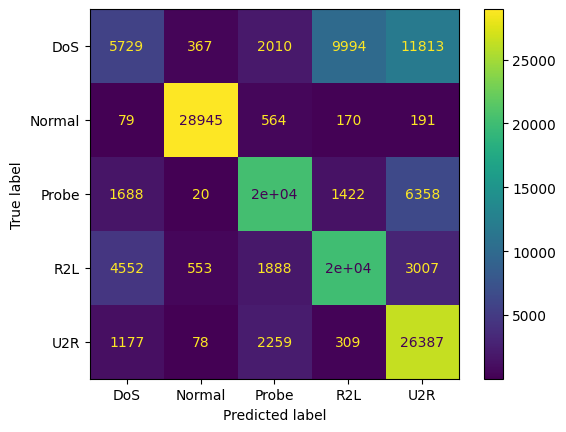

In [79]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)

In [80]:
coefficients = clf.coef_[0]
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

coeff_df.T

,15,8,14,2,1,22,23,12,7,18,17,9,13,21,16,5,19,0,3,6,10,4,11,20,24
Feature,Dpkts,dloss,ct_src_dport_ltm,ct_srv_dst,sbytes,dbytes,Sjit,proto_udp,service_missing,ct_dst_sport_ltm,res_bdy_len,ct_srv_src,ct_dst_ltm,synack,Djit,stcpb,ackdat,sttl,ct_dst_src_ltm,dtcpb,Sload,ct_src_ltm,smeansz,Sintpkt,Stime
Coefficient,5.125847,-2.692913,1.890837,-1.334713,0.966825,0.913334,-0.730608,-0.675303,-0.548562,-0.520929,0.39967,-0.316313,-0.297935,-0.271519,-0.256086,-0.251796,0.220016,0.200624,0.194693,-0.184794,0.135522,-0.064803,0.043293,-0.029596,0.007285
Abs_Coefficient,5.125847,2.692913,1.890837,1.334713,0.966825,0.913334,0.730608,0.675303,0.548562,0.520929,0.39967,0.316313,0.297935,0.271519,0.256086,0.251796,0.220016,0.200624,0.194693,0.184794,0.135522,0.064803,0.043293,0.029596,0.007285


### Cross validation 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns

Use cross validation with 5 splits

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
Define the model

In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=42)
fold_results = []

Use cross validation with undersampling and SMOTE for training the model

In [ ]:
for fold, (train_idx, test_idx) in enumerate(skf.split(train_x, train_Y)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    X_train_raw, X_test_raw = train_x.iloc[train_idx], train_x.iloc[test_idx]
    y_train, y_test = train_Y.iloc[train_idx], train_Y.iloc[test_idx]

    sampling_strategy = {"Normal": 100000}
    under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_under, y_train_under = under_sampler.fit_resample(X_train_raw, y_train)
    
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test_raw)
    
    clf.fit(X_train_scaled, y_train_balanced)
    
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    fold_results.append({
        'Fold': fold + 1,
        'Accuracy': acc,
        'Precision (weighted)': report['weighted avg']['precision'],
        'Recall (weighted)': report['weighted avg']['recall'],
        'F1-Score (weighted)': report['weighted avg']['f1-score'],
        'Confusion Matrix': cm
    })

    print(pd.DataFrame(report).T)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.show()

In [ ]:
results_df = pd.DataFrame(fold_results)
print("\n--- Summary of Results ---")
print(results_df[['Fold', 'Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)']])

In [ ]:
summary_stats = results_df[['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)']].agg(['mean', 'std'])
print("\n--- Overall Performance ---")
print(summary_stats)

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars=['Fold'], 
                                 value_vars=['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)']), 
            x='variable', y='value', hue='Fold', palette='viridis')
plt.title("Performance Metrics Across Folds")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.legend(title="Fold", loc="upper right")
plt.show()